In [55]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [57]:
pickle_file = 'notMNIST_clean.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8913, 28, 28) (8913,)
Test set (8695, 28, 28) (8695,)


In [58]:
image_size = 28
num_labels = 10 # Extra label for the empty character
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    #(-1, image_size, image_size, num_channels)).astype(np.float32) # Conv net
    (-1, image_size, image_size)).astype(np.float32)  # Deep net
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000, 10)
Validation set (8913, 28, 28) (8913, 10)
Test set (8695, 28, 28) (8695, 10)


In [5]:
# Create an empty character
empty_label = np.zeros(num_labels)
empty_label[-1] = 1.
print(empty_label)
print(train_labels[:10])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


With training data
Image shape: (48, 440)


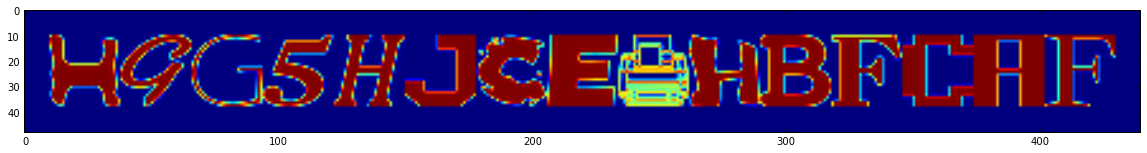

Label shape: (15, 10)
HGGEHJCEGHBFCAF
With testing data
Image shape: (48, 300)


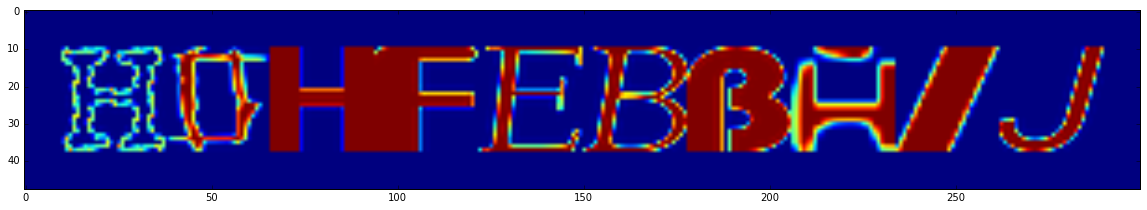

Label shape: (10, 10)
HIHFEBBAIJ
Image shape: (48, 160)


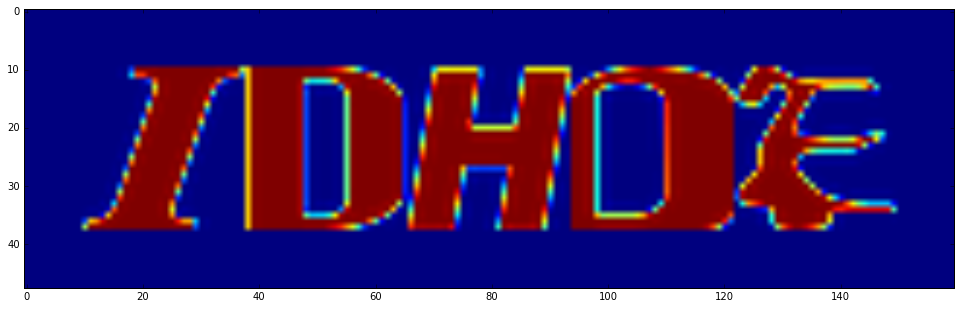

Label shape: (5, 10)
IDHDE
Image shape: (48, 160)


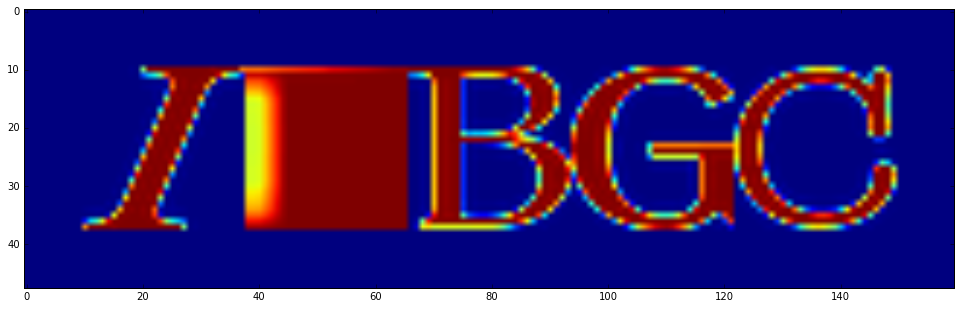

Label shape: (5, 10)
IIBGC
Image shape: (48, 160)


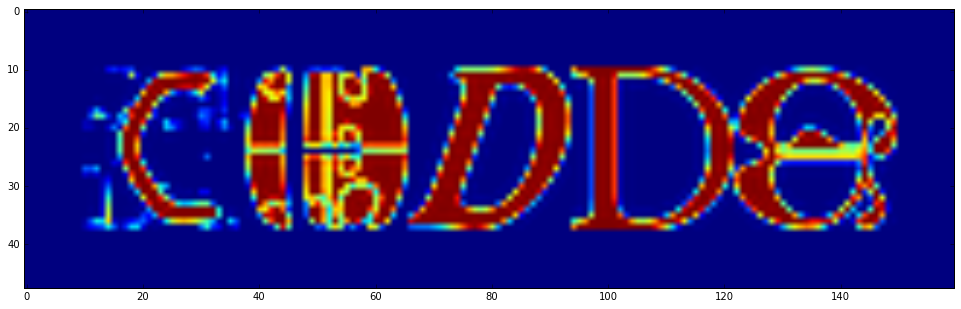

Label shape: (5, 10)
CEDDE


In [60]:
# Create a sequence of digits from the training data
#
# returns (joined image, labels)
def create_sequence(train, labels, length=5):
    rand_length = length #np.random.randint(length) + 1
        
    spacing = 10
    digit_height = train.shape[1]
    digit_width = train.shape[2]
    
    img_height = digit_height + spacing * 2
    img_width = digit_width * length + spacing * 2
    
    result_image = np.ones([img_height, img_width]).astype(np.float32) * -0.5
    
    x = spacing + int(digit_width * (length - rand_length) / 2.)
    y = spacing
    
    result_labels = [empty_label] * length
    
    for a in range(rand_length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])
        
        img = train[index]
        
        #print(y,digit_height, x, digit_width)
        result_image[y:y+digit_height, x:x+digit_width] = img
        x = x + digit_width
        
        result_labels[(length - rand_length) // 2 + a] = labels[index]
    
    result_labels = np.array(result_labels)
    
    return result_image, result_labels
           
def show_image(data):
    print("Image shape:", data.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(data)
    plt.show()
    
def show_label(label):
    print("Label shape:", label.shape)
    result = ''
    for a in label:
        index = np.argmax(a)
        if index == 11:
            result += '.'
        else:
            result += chr(ord('A') + index)
    print(result)
    
print("With training data")
image, label = create_sequence(train_dataset, train_labels, length=15)
show_image(image)
show_label(label)

print("With testing data")
image, label = create_sequence(test_dataset, test_labels, length=10)
show_image(image)
show_label(label)

# Create a batch of images and labels
def generate_batch(data, labels, size, length, **kwargs):    
    images, labels = zip(*[create_sequence(data, labels, length, **kwargs) for i in range(size)])
        
    result_images = np.array(images)
    result_labels = np.array(labels)
    
    return result_images, result_labels

images, labels = generate_batch(train_dataset, train_labels, 3, 5)

for i in range(len(labels)):
    show_image(images[i])
    show_label(labels[i])

Validation shape: (2000, 48, 160) (2000, 5, 10)
Testing shape: (2000, 48, 160) (2000, 5, 10)
Image shape: (48, 160)


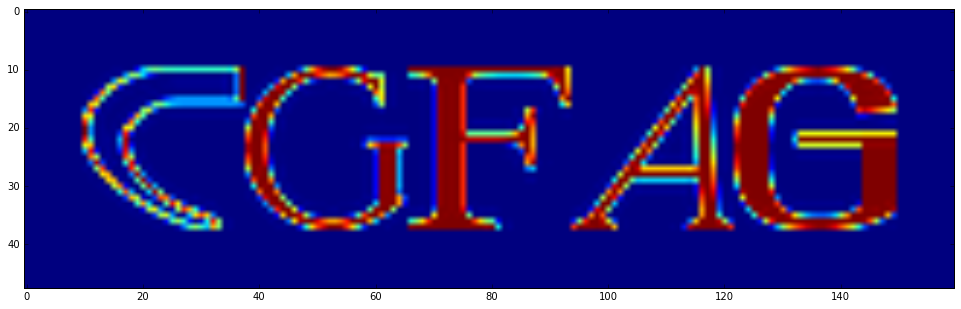

Label shape: (5, 10)
CGFAG
Image shape: (48, 160)


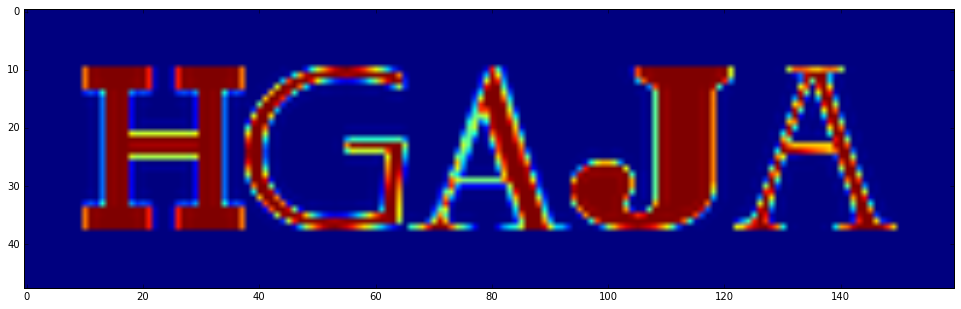

Label shape: (5, 10)
HGAJA


In [61]:
# Lets create our training, validation and testing datasets
num_digits = 5

# Lets use less validations as the pictures a a lot bigger
#train_dataset_imgs, train_dataset_labels = generate_batch(train_dataset, train_labels, 200000, num_digits)
valid_dataset_imgs, valid_dataset_labels = generate_batch(valid_dataset, valid_labels, 2000, num_digits)
test_dataset_imgs, test_dataset_labels = generate_batch(test_dataset, test_labels, 2000, num_digits)

#print("Training shape:", train_dataset_imgs.shape, train_dataset_labels.shape)
print("Validation shape:", valid_dataset_imgs.shape, valid_dataset_labels.shape)
print("Testing shape:", test_dataset_imgs.shape, test_dataset_labels.shape)

show_image(valid_dataset_imgs[110])
show_label(valid_dataset_labels[110])
show_image(test_dataset_imgs[110])
show_label(test_dataset_labels[110])

In [40]:
batch_size = 128

img_height = test_dataset_imgs.shape[1]
img_width = test_dataset_imgs.shape[2]
    
num_labels = 11 # [0-9] + blank

stride = 1
patch_size = 5
depth = 16
hidden = 64
num_channels = 1

graph = tf.Graph()
with graph.as_default():
    
    #
    # Create the input image placeholder
    #
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                 img_height,
                                                 img_width,
                                                 num_channels), name="tf_train_dataset")
        
    # Conv1 weights and biases
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                     patch_size,
                                                     num_channels,
                                                     depth], stddev=0.1, name="layer1_weights"))
    layer1_biases = tf.Variable(tf.zeros([depth]), name="layer1_biases")
    
    # Conv2 weights and biases
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                      patch_size,
                                                      depth,
                                                      depth], stddev=0.1), name="layer2_weights")
    layer2_biases = tf.Variable(tf.zeros([depth]), name="layer2_biases")
    
    #Create fully connected layer
    layer3_weights = tf.Variable(tf.truncated_normal([img_height // 4 * img_width // 4 * depth,
                                                      hidden]), name="layer3_weights")
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[hidden]), name="layer3_biases")
    
    # Multi classifier output, one for each digit
    layer4_weights = tf.Variable(tf.truncated_normal([hidden,
                                                      num_digits * num_labels], stddev=0.1), name="layer4_weights")
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_digits * num_labels]), name="layer4_biases")
    

    #
    # Design the convnet model
    #
    def model(tf_input):
        
        conv1 = tf.nn.conv2d(tf_input, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        
        conv2 = tf.nn.conv2d(hidden1, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + layer2_biases)
        
        shape2 = hidden2.get_shape().as_list()
        reshape3 = tf.reshape(hidden2, [shape2[0], shape2[1] * shape2[2] * shape2[3]])
        hidden3 = tf.nn.relu(tf.matmul(reshape3, layer3_weights) + layer3_biases)
        
        tf_output = tf.matmul(hidden3, layer4_weights) + layer4_biases       
        return tf_output
    
   
    #
    # Create the loss function
    #
    # Training computation.
    logits = model(tf_train_dataset)
    tf_train_labels = tf.placeholder(tf.float32, 
                                     shape=(batch_size, 
                                            num_digits,
                                            num_labels), 
                                     name="tf_train_labels")
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels), name="loss")
    
    
    #
    # Create the optimizer
    #
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    


    #
    # Create a predictor for the training set
    #
    train_prediction = tf.nn.softmax(logits)


    #
    # Create a predictor for the validation set
    #
    # we need to add the extra dimension for the convnet
    new_shape = list(valid_dataset_imgs.shape[:]) + [1]
    reshape = np.reshape(valid_dataset_imgs, new_shape)
    tf_valid_dataset = tf.constant(reshape)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        
    
    
    #
    # Create a predictor for the test set
    #
    # we need to add the extra dimension for the convnet
#     new_shape = list(test_dataset_imgs.shape[:]) + [1]
#     reshape = np.reshape(test_dataset_imgs, new_shape)
#     tf_train_dataset = tf.constant(reshape)
#     train_prediction = tf.nn.softmax(model(tf_train_dataset))

In [45]:
num_steps = 201

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
    
  for step in range(num_steps):
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    batch_data, batch_labels = generate_batch(train_dataset, train_labels, batch_size, num_digits)
    
    batch_data = np.reshape(batch_data, list(batch_data.shape) + [1])
    batch_labels = np.reshape(batch_labels, [batch_labels.shape[0], -1])
        
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer,
                                     loss,
                                     train_prediction], feed_dict=feed_dict)
        
    if (step % 50 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    
    if not np.isfinite(l):
        raise Exception("Loss is out of control:%f" %l)
    
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


TypeError: unhashable type: 'list'

In [62]:
# NN Helpers

# Create weights and biases
def new_wb(dimensions):
    """Create weights and biases bases on the first 2 dimensions"""
    weights = tf.Variable(tf.truncated_normal(dimensions))
    biases = tf.Variable(tf.truncated_normal(dimensions[1:]))
    return weights, biases

# Create a list of weights biases
def create_weights(dimensions):
    """Create a list of tuples like [(weights, biases), (weights, biases), ..]"""
    result = []
    for i in range(len(dimensions) -1):
        result.append(new_wb(dimensions[i:i+2]))
    return result

def create_nn(tensor_input, weights, modifiers=None):    
    """Create nn using weights and modifiers. By default creates y=x.w+b 
    
    Layers is a list of modifiers, one for each layer such as
           layers_train = [
               [tf.nn.relu, lambda x: tf.nn.dropout(x, 0.5)], # Use this in layer 1
               [],
           ]
    """
    if modifiers is not None:
        if len(weights) <> len(modifiers):
            raise Exception("Weights and layers must be the same size")
                
    for i in range(len(weights)):
        
        # Get the weights and biases from the array
        w, b = weights[i]
        
        # (x * weights + biases)
        new_layer = tf.add(tf.matmul(tensor_input, w), b) 
        
        # Run the modifiers, like relu...
        if modifiers is not None:
            for modifier in modifiers[i]:
                new_layer = modifier(new_layer)
            
        # This will be the input fo the next layer
        tensor_input = new_layer
    return tensor_input

def create_multi_output_nn(tf_input, count, weight_dims, modifiers=None):
    """Create multiple output tensors
    
    returns
        weights : list of (weights, biases) : the weights that were created
        tensors : list of Tensor : the tensors that were created
    """
    weights = [
        create_weights(weight_dims)
        for i in range(count)
    ]
    tf_output = [
        create_nn(tf_input, weights[i], modifiers)
        for i in range(count)
    ]

    return weights, tf_output


In [63]:
batch_size = 128
input_size = valid_dataset_imgs.shape[1] * valid_dataset_imgs.shape[2]

graph = tf.Graph()
with graph.as_default():
    
    #
    # Create the input image placeholder
    #
    tf_input = tf.placeholder(tf.float32, shape=(batch_size, input_size), name="b_input")
    
    
    
    #
    # Create the input nn
    #
        
    # The weights for out main net
    weights_main_dims = [
        input_size,  # Image input size
        100  # main output
    ]
    
    # The weights for out main net
    weights_main = create_weights(weights_main_dims)
    
    # The main net
    tf_main = create_nn(tf_input, weights_main)
    

    
    
    #
    # Create the output classifiers, one for each digit
    #
        
    # Create multi output classifiers
    weights_outputs, tf_outputs = create_multi_output_nn(
        tf_main,
        num_digits,
        [weights_main_dims[-1], num_labels]
    )
    
    
    
    #
    # Create the labels, one for each digit
    #
    tf_train_labels = [
        tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='b_label_%s' % i)
        for i in range(num_digits)
    ]
        
        
        
    #
    # Create the loss function
    #
    loss_fully_connected = [
        tf.nn.softmax_cross_entropy_with_logits(
            tf_outputs[i],
            tf_train_labels[i]
        )
        for i in range(num_digits)]
    loss = tf.reduce_mean(loss_fully_connected)
    
    
    
    #
    # Create the optimizer
    #
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    



    #
    # Create a predictor for the training set
    #
    graph_train_prediction = [
        tf.nn.softmax(tf_outputs[i])
        for i in range(num_digits)
    ]

    
    #
    # Create a predictor for the validation set
    #
    tf_valid_dataset = tf.constant(np.reshape(valid_dataset_imgs, [valid_dataset_imgs.shape[0], -1]))
    # validation tensor
    graph_valid_prediction = [
        tf.nn.softmax(
            create_nn(
                create_nn(tf_valid_dataset, weights_main), # The main graph with validation input
                weights_outputs[i]
            )
        )
        for i in range(num_digits)]

    
    
    #
    # Create a predictor for the test set
    #
    tf_test_dataset = tf.constant(np.reshape(test_dataset_imgs, [test_dataset_imgs.shape[0], -1]))
    # Test tensor
    graph_test_prediction = [
        tf.nn.softmax(
            create_nn(
                create_nn(tf_test_dataset, weights_main), # The main graph with test input
                weights_outputs[i]
            )
        )
        for i in range(num_digits)]


In [64]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 501

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):

        #
        # Generate a minibatch.
        #
        # Tese batches will always be random
        batch_data, batch_labels = generate_batch(train_dataset, train_labels, batch_size, num_digits)

        
        #
        # Ensure the feed_dict is loaded up correctly
        #
        
        feed_dict = {}
        
        # Add the input batch to the feed_dict
        feed_dict[tf_input] = np.reshape(batch_data, [batch_data.shape[0], -1])
        
        # Add the labels to the correct output tensors
        for i in range(num_digits):
            output_tensor = tf_train_labels[i]
            output_labels = batch_labels[:, i, :]
            feed_dict[output_tensor] = output_labels


            
        #
        # Create the graphs we want to execute and run :-)
        #
        fetches = [optimizer, loss] + graph_train_prediction
        result = session.run(fetches, feed_dict=feed_dict)    


        #
        # Check our stats
        #
        if (step % 100 == 0):
            print("Minibatch loss at step %d: %f" % (step, result[1]))
            train_predictions = result[2:]

            # Lets compare the train predictions
            train_accuracy = np.mean([
                    accuracy(train_predictions[i], batch_labels[:, i, :])
                    for i in range(num_digits)
                ])

            valid_accuracy = np.mean([
                    accuracy(graph_valid_prediction[i].eval(), valid_dataset_labels[:, i, :])
                    for i in range(num_digits)
                ])

            print("Minibatch accuracy: %.1f%%" % train_accuracy)
            print("Validation accuracy: %.1f%%" % valid_accuracy)

    #
    # How did we do on the test set?
    #
    test_accuracy = np.mean([
            accuracy(graph_test_prediction[i].eval(), test_dataset_labels[:, i, :])
            for i in range(num_digits)
        ])
    print("Test accuracy: %.1f%%" % test_accuracy)

Initialized
Minibatch loss at step 0: 458.078857
Minibatch accuracy: 10.6%
Validation accuracy: 11.2%
Minibatch loss at step 100: nan
Minibatch accuracy: 11.1%
Validation accuracy: 9.9%
Minibatch loss at step 200: nan
Minibatch accuracy: 9.2%
Validation accuracy: 9.9%
Minibatch loss at step 300: nan
Minibatch accuracy: 9.8%
Validation accuracy: 9.9%
Minibatch loss at step 400: nan
Minibatch accuracy: 10.6%
Validation accuracy: 9.9%
Minibatch loss at step 500: nan
Minibatch accuracy: 11.9%
Validation accuracy: 9.9%
Test accuracy: 10.2%
